# How to inject artifical signals into K2 light curves

`lightkurve` will include a method to inject artificial signals (e.g. supernovae, planetary transits, rotation, flares) into K2, Kepler, TESS, and potentially ground based light curves. 

Let's download a K2 light curve of a galaxy. Currently, injection works on the light curve level, so we'll need to construct a light curve from the target pixel file.

In [63]:
from lightkurve import KeplerTargetPixelFile
import matplotlib.pyplot as plt
import numpy as np

tpf = KeplerTargetPixelFile.from_archive(220381074)   #KeplerTargetPixelFile
lc = tpf.to_lightcurve(aperture_mask='all')           #KeplerLightCurve

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()              

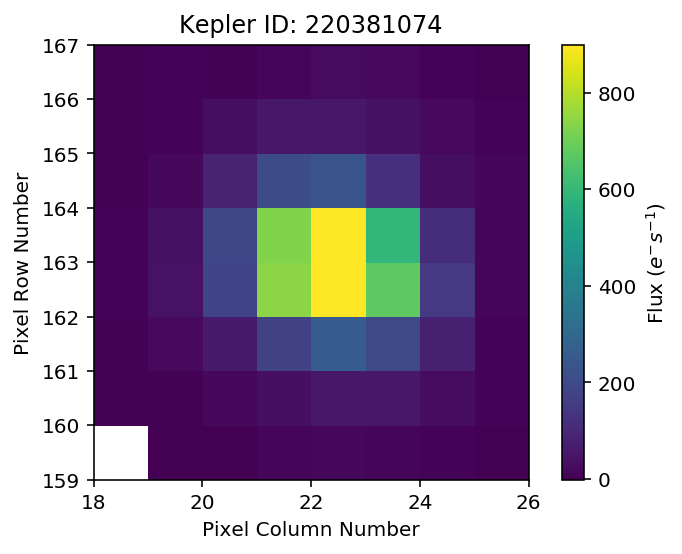

In [64]:
tpf.plot()

(0, 1.5)

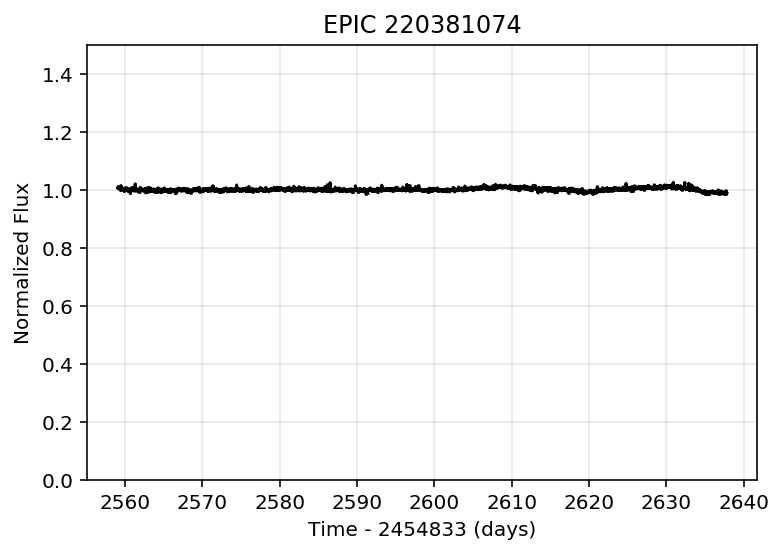

In [65]:
lc.plot();
plt.title('EPIC 220381074')
plt.ylim(0, 1.5)

This light curve of this galaxy is fairly smooth, but there may be some variability from the spacecraft motion and thermal fluctuations.
Now let's inject a supernova with the new `.inject` method, and plot the K2 light curve next to it. You'll need to install [sncosmo](http://sncosmo.readthedocs.io/) for this method to work.

(0.8, 1.2)

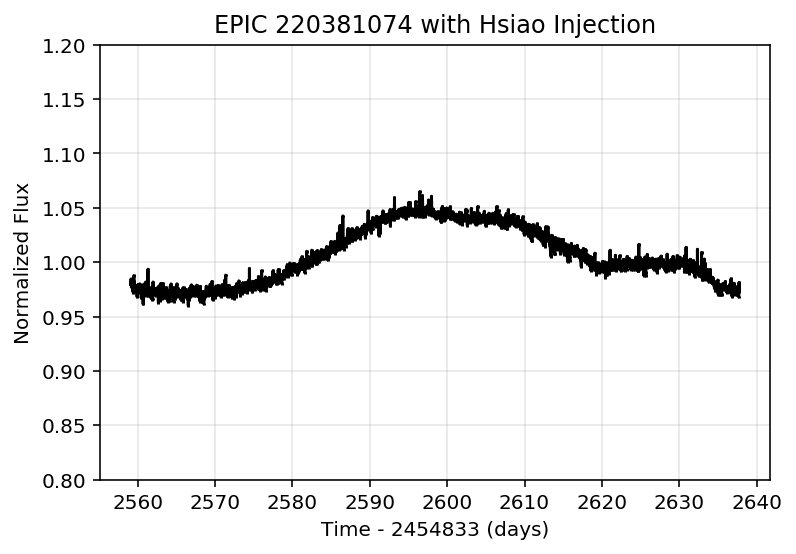

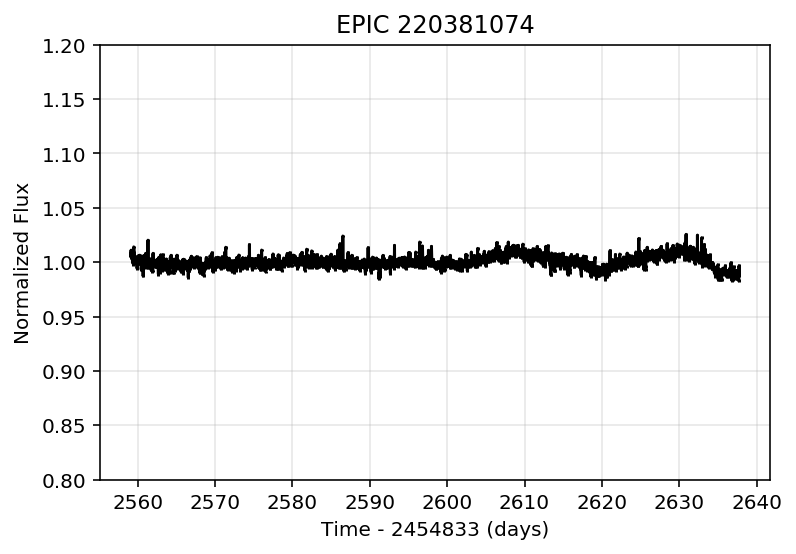

In [66]:
lcinj = lc.inject(t0=np.nanmedian(lc.time), source='hsiao', z=0.5, amplitude=2.e-4)

#K2 light curve with injection
lcinj.plot()
plt.title('EPIC 220381074 with Hsiao Injection')
plt.ylim(0.8,1.2)

#K2 light curve
lc.plot()
plt.title('EPIC 220381074')
plt.ylim(0.8,1.2)

We injected a supernova light curve into this galaxy!

This supernova is based on the [Hsiao](http://adsabs.harvard.edu/abs/2007ApJ...663.1187H) source 
and takes three parameters: redshift $z$, amplitude, and $t_0$ (time of zero phase). 
<br>
(Note: depending on the source, $t_0$ may specify the beginning or the peak of the supernova.)
<br>

You can specify the source and input the parameters belonging to this source accordingly. For example, let's simulate a supernova with the SALT2 model, which takes 5 parameters ($t_0$, $z$, $x_0$, $x_1$, and $c$):

(0.8, 1.2)

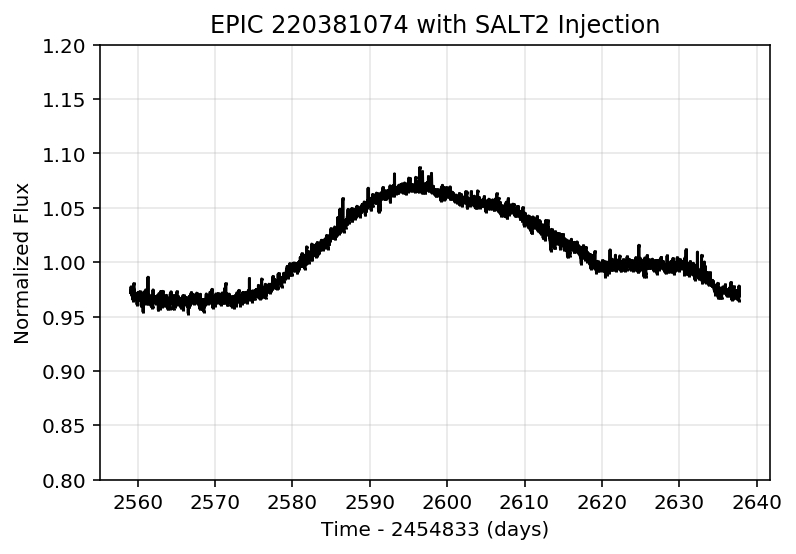

In [67]:
lcinjSALT2 = lc.inject(t0=np.nanmedian(lc.time), source='salt2', z=0.5, x0=5, x1=1.e-6, c=-0.1)

lcinjSALT2.plot()
plt.title('EPIC 220381074 with SALT2 Injection')
plt.ylim(0.8,1.2)